QUESTION: 1


Description:

Edge Detection (Canny): Edge detection is a crucial step used to identify potential tumor boundaries within a mammogram. In the code, we employ the Canny edge detection algorithm to highlight regions in the mammogram where there are rapid changes in pixel intensity. These highlighted edges may correspond to tumor edges, making them easier to distinguish from the surrounding tissue.

Tumor Region Localization: After detecting edges, we perform additional image processing, including dilation and erosion, to enhance and refine the detected edge regions. This step helps localize and refine the potential tumor areas, providing a clearer representation of tumor boundaries.

Local Binary Pattern (LBP) Texture Analysis: Texture analysis plays a pivotal role in detecting tumors by capturing patterns related to tumor tissue. We employ the Local Binary Pattern (LBP) technique to extract texture features from the mammogram. LBP operates by comparing the intensity values of pixels within local neighborhoods. By encoding local texture patterns into histograms, LBP provides valuable information about the texture variations present in the mammogram, aiding in tumor detection.

Displaying Results: The code further enhances the understanding of the process by displaying the original mammogram, the edge-detected image, and the LBP image side by side. This visual representation allows for a comprehensive assessment of how edge detection and LBP contribute to the identification of potential tumor regions.

Explanation: Edge detection highlights potential tumor boundaries, while LBP focuses on capturing local texture patterns. Combining these techniques with proper post-processing and machine learning can significantly enhance tumor detection in medical images like mammograms.

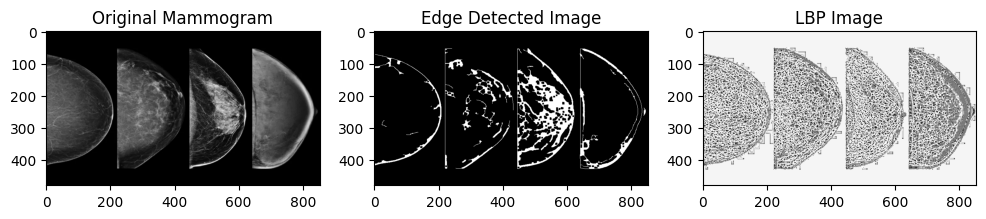

Edge detection is used to find boundaries in the image that may correspond to tumor edges.
Local Binary Pattern (LBP) captures local texture patterns, which can be indicative of tumors.


In [28]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from skimage import exposure
import matplotlib.pyplot as plt

# Load the Mammogram Image
image = cv2.imread('mammography.jpg', cv2.IMREAD_GRAYSCALE)

# Step 1: Preprocess the Image
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Step 2: Edge Detection using Canny
edges = cv2.Canny(blurred, 50, 150)

# Step 3: Tumor Region Localization (Dilation and Erosion)
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=1)
eroded = cv2.erode(dilated, kernel, iterations=1)

# Step 4: Feature Extraction (LBP)
radius = 3
n_points = 24
lbp_image = local_binary_pattern(image, n_points, radius, method='uniform')

# Step 5: Enhance the LBP image for better visualization
lbp_image = exposure.rescale_intensity(lbp_image, in_range=(0, n_points+3))

# Display Images Side by Side
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original Mammogram')

plt.subplot(132)
plt.imshow(eroded, cmap='gray')
plt.title('Edge Detected Image')

plt.subplot(133)
plt.imshow(lbp_image, cmap='gray')
plt.title('LBP Image')

plt.show()

# Step 6: Explanation
print("Edge detection is used to find boundaries in the image that may correspond to tumor edges.")
print("Local Binary Pattern (LBP) captures local texture patterns, which can be indicative of tumors.")


In [29]:
QUESTION: 2

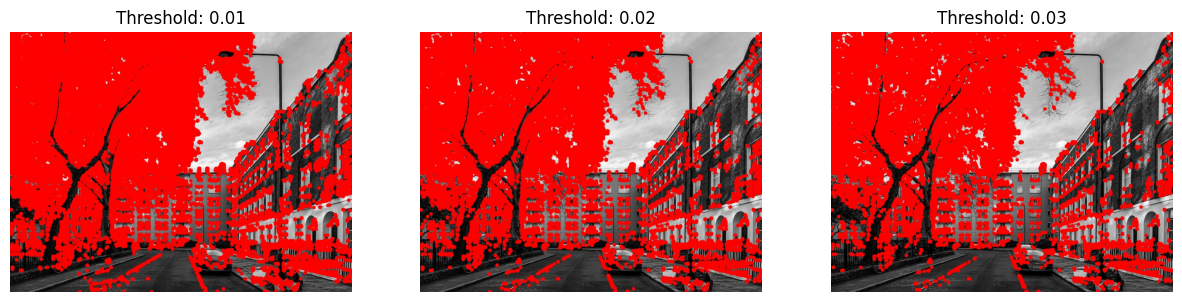

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('p1.jpg', cv2.IMREAD_GRAYSCALE)
block_size = 2
k = 0.04

threshold_values = [0.01, 0.02, 0.03]
output_paths = ['output_image_1.jpg', 'output_image_2.jpg', 'output_image_3.jpg']

def update_corners(threshold_value, output_path):
    corner_scores = cv2.cornerHarris(image, block_size, 3, k)
    threshold = threshold_value * corner_scores.max()
    corners = np.where(corner_scores > threshold)
    image_with_corners = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for y, x in zip(*corners):
        cv2.circle(image_with_corners, (x, y), 5, (0, 0, 255), -1)

    cv2.putText(image_with_corners, f'Threshold: {threshold_value}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv2.imwrite(output_path, image_with_corners)

for threshold_value, output_path in zip(threshold_values, output_paths):
    update_corners(threshold_value, output_path)

# Display images side by side using Matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (output_path, threshold_value) in enumerate(zip(output_paths, threshold_values)):
    image = cv2.imread(output_path)
    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Threshold: {threshold_value}')
    axes[i].axis('off')

plt.show()


In [31]:
QUESTION: 4

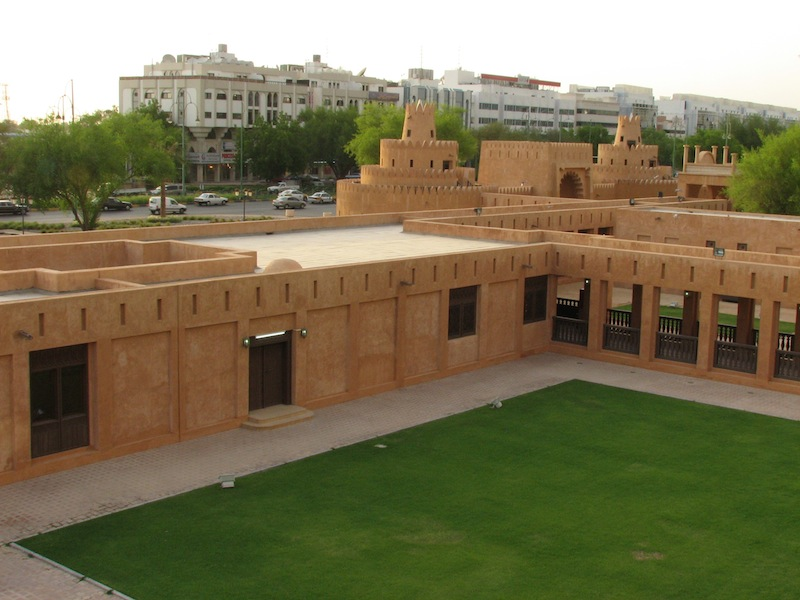

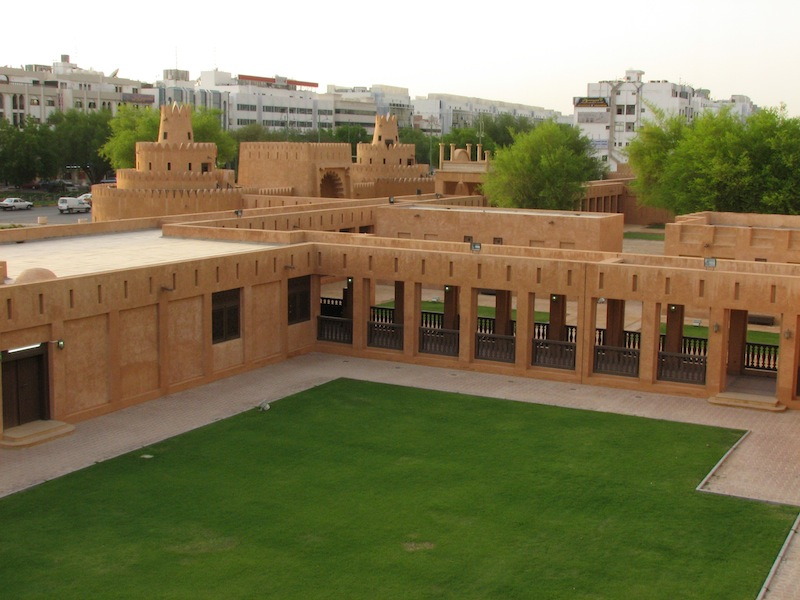

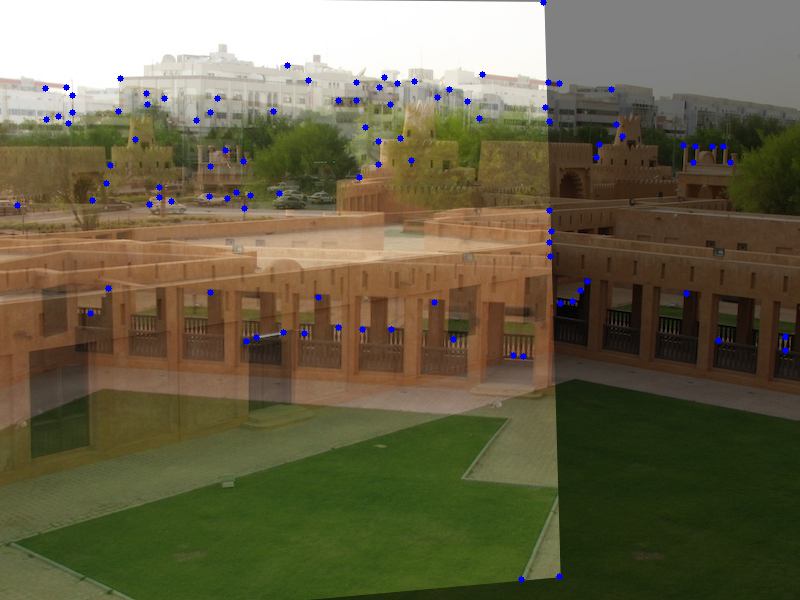

In [54]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_corners(image, method='Harris'):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if method == 'Harris':
        # Harris Corner Detection
        corners = cv2.cornerHarris(gray, 2, 3, 0.04)
    elif method == 'Shi-Tomasi':
        # Shi-Tomasi Corner Detection
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.01, minDistance=10)

    corners = np.int0(corners)

    for corner in corners:
        x, y = corner.ravel()
        cv2.circle(image, (x, y), 3, 255, -1)

    return image, corners

def stitch_images(images):
    detector = cv2.ORB_create()
    keypoints_list = []
    descriptors_list = []

    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = detector.detectAndCompute(gray, None)
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matching_pairs = []

    for i in range(len(images) - 1):
        matches = bf.match(descriptors_list[i], descriptors_list[i+1])
        matches = sorted(matches, key=lambda x: x.distance)
        matching_pairs.append((i, i+1, matches))

    stitched_images = [images[0]]

    for pair in matching_pairs:
        img1_idx, img2_idx, matches = pair
        img1 = stitched_images[img1_idx]
        img2 = images[img2_idx]

        src_pts = np.float32([keypoints_list[img1_idx][m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_list[img2_idx][m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        h, w, _ = img1.shape
        img2_warped = cv2.warpPerspective(img2, M, (w, h))
        result = cv2.addWeighted(img1, 0.5, img2_warped, 0.5, 0)

        stitched_images.append(result)

    return stitched_images[-1]

image1 = cv2.imread('img1.jpg')
image2 = cv2.imread('img2.jpg')
images_to_stitch = [image1, image2]

# Display original images with detected corners
for image in images_to_stitch:
    cv2_imshow(image)
    cv2.waitKey(0)

# Display the stitched image with detected corners
result_image = stitch_images(images_to_stitch)
result_image_with_corners, _ = detect_corners(result_image, method='Shi-Tomasi')  # Change method to 'Harris' if needed
cv2_imshow(result_image_with_corners)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [33]:
QUESTION: 5

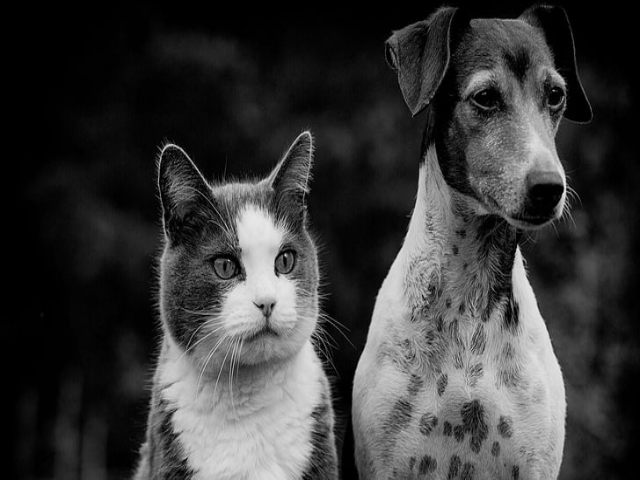

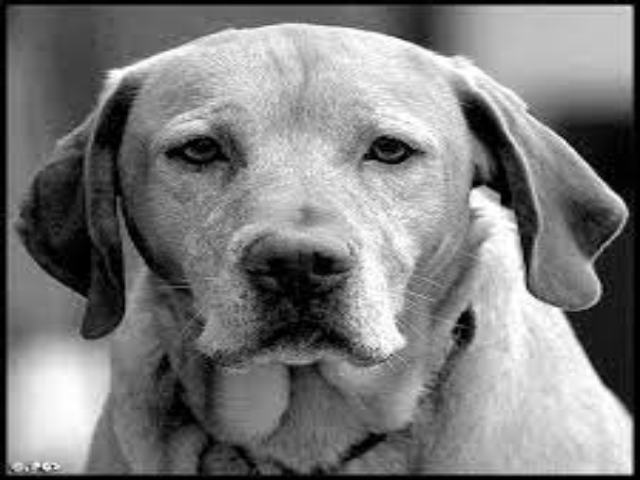

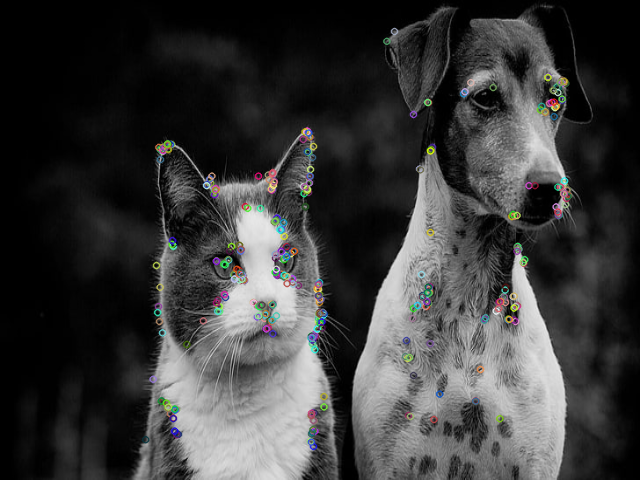

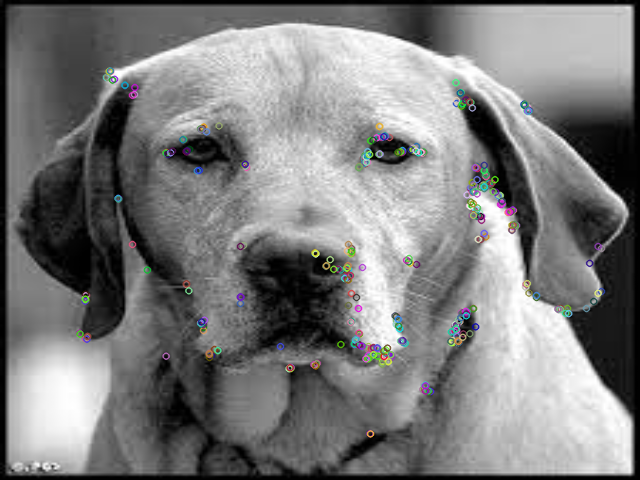

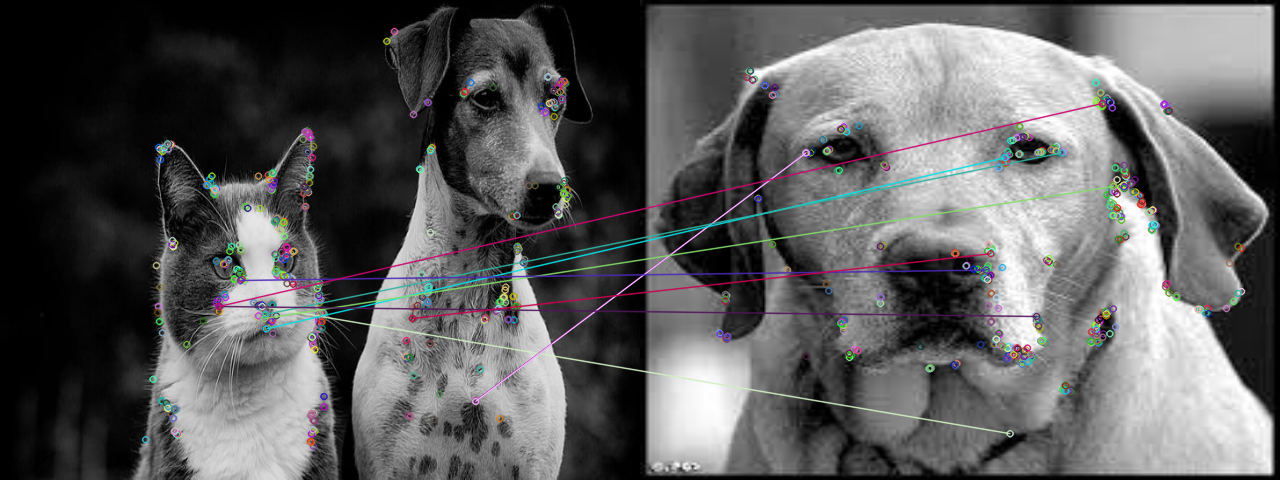

In [51]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load two images
image1 = cv2.imread('cd.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('d1.jpg', cv2.IMREAD_GRAYSCALE)

desired_size = (640, 480)
image1 = cv2.resize(image1, desired_size)
image2 = cv2.resize(image2, desired_size)

# Initialize ORB detector
orb = cv2.ORB_create()

keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(descriptors1, descriptors2)

matches = sorted(matches, key=lambda x: x.distance)

matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], outImg=None)

cv2_imshow(image1)
cv2_imshow(image2)
cv2_imshow(cv2.drawKeypoints(image1, keypoints1, None))
cv2_imshow(cv2.drawKeypoints(image2, keypoints2, None))
cv2_imshow(matched_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
